In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import PIL, cv2, os, imghdr

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
data_dir = 'datasets/flower_photos' 

In [4]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [33]:
def generate_image_data(img_x, img_y, data_dir, seed=42):
    '''
    Based of X, y and image location, returns dataset
    '''
    tf.random.set_seed(seed)
    data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_x, img_y))
    data = data.map(lambda x, y: (x/255, y))
    return data

def generate_train_val_test(data, seed=42):
    tf.random.set_seed(seed)
    train_size = int(len(data) * 0.7)
    val_size = int(len(data) * 0.1)
    test_size = int(len(data) * 0.2)
    
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size + val_size).take(test_size)
    return train, val, test

def apply_augmentation(img_x, img_y, factor, seed=42):
    tf.random.set_seed(seed)
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_x, img_y, 3)),
            layers.experimental.preprocessing.RandomRotation(factor),
            layers.experimental.preprocessing.RandomZoom(factor),
        ]
    )
    return data_augmentation

def lr_scheduler(epoch, lr):
    if epoch < 7:
        return lr
    return lr * tf.math.exp(-0.1)

# Experiment 1 (VGG like model)

In [7]:
img_dim = 128

In [8]:
data = generate_image_data(img_dim, img_dim, data_dir, seed=42)

Found 6173 files belonging to 6 classes.


In [9]:
train, val, test = generate_train_val_test(data, seed=42)

In [10]:
data_augmentation = apply_augmentation(img_dim, img_dim, 0.1, seed=42)

In [11]:
logdir='logs'

In [12]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
tf.keras.backend.clear_session()

In [35]:
num_classes = 6
batch_size = 32
epochs = 30
tf.random.set_seed(42)

In [36]:
lr_schedule = LearningRateScheduler(lr_scheduler)

model = Sequential([
    data_augmentation,

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    
    layers.Flatten(),

    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
#     layers.Dense(16, activation='relu'),

    
    layers.Dense(num_classes)
])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist_aug = model.fit(train,  epochs=epochs, batch_size = batch_size, validation_data=val,\
                     callbacks=[tensorboard_callback, early_stopping, lr_schedule])


Epoch 1/30
135/135 [==============================] - 90s 651ms/step - loss: 1.7412 - accuracy: 0.2412 - val_loss: 1.5678 - val_accuracy: 0.3257 - lr: 0.0020
Epoch 2/30
135/135 [==============================] - 105s 777ms/step - loss: 1.4748 - accuracy: 0.3942 - val_loss: 1.3410 - val_accuracy: 0.4803 - lr: 0.0020
Epoch 3/30
135/135 [==============================] - 93s 688ms/step - loss: 1.3550 - accuracy: 0.4801 - val_loss: 1.2407 - val_accuracy: 0.5362 - lr: 0.0020
Epoch 4/30
135/135 [==============================] - 85s 630ms/step - loss: 1.2623 - accuracy: 0.5144 - val_loss: 1.1921 - val_accuracy: 0.5510 - lr: 0.0020
Epoch 5/30
135/135 [==============================] - 86s 633ms/step - loss: 1.2049 - accuracy: 0.5495 - val_loss: 1.1115 - val_accuracy: 0.6053 - lr: 0.0020
Epoch 6/30
135/135 [==============================] - 86s 634ms/step - loss: 1.1369 - accuracy: 0.5771 - val_loss: 0.9935 - val_accuracy: 0.6184 - lr: 0.0020
Epoch 7/30
135/135 [==============================]

In [39]:
model.evaluate(test)

38/38 [==============================] - 12s 214ms/step - loss: 0.8414 - accuracy: 0.6916


[0.8413966298103333, 0.6916118264198303]

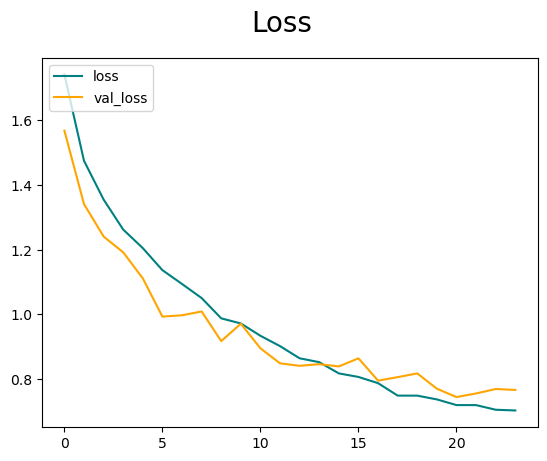

In [40]:
fig = plt.figure()
plt.plot(hist_aug.history['loss'], color='teal', label='loss')
plt.plot(hist_aug.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist_aug.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_aug.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save('saved_models/cnn_8125.keras')

In [ ]:
model.weights

In [ ]:
test = load_model('saved_models/cnn_7679.keras')

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
image_path = './test_images/rose_1.jpeg'   
image = cv2.imread(image_path)
resized_image = cv2.resize(image, (120, 120))
resized_image = np.expand_dims(resized_image, axis=0)


In [ ]:
preprocessed_image = preprocess_input(resized_image)
predictions = loaded_model.predict(preprocessed_image)

In [ ]:

np.argmax(predictions)

In [41]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Assuming `test` is your test dataset and `model` is your trained model
class_names = [str(i) for i in range(6)]  # Assuming 6 classes
num_classes = len(class_names)

precision_metrics = [Precision() for _ in range(num_classes)]
recall_metrics = [Recall() for _ in range(num_classes)]

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    
    for i in range(num_classes):
        class_label = i
        class_true = tf.cast(tf.equal(y, class_label), tf.float32)
        class_pred = tf.cast(tf.equal(tf.argmax(yhat, axis=1), class_label), tf.float32)

        precision_metrics[i].update_state(class_true, class_pred)
        recall_metrics[i].update_state(class_true, class_pred)

precision_results = [precision_metric.result().numpy() for precision_metric in precision_metrics]
recall_results = [recall_metric.result().numpy() for recall_metric in recall_metrics]

# Calculate F1 score for each class
f1_results = [2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
              for precision, recall in zip(precision_results, recall_results)]

print("Precision for each class:", precision_results)
print("Recall for each class:", recall_results)
print("F1 score for each class:", f1_results)

1/1 [==============================] - 0s 171ms/step
Precision for each class: [0.77840906, 0.74725276, 0.5767635, 0.81, 0.5833333, 0.74261606]
Recall for each class: [0.6954315, 0.6126126, 0.62053573, 0.8019802, 0.5645161, 0.95135134]
F1 score for each class: [0.7345844653644972, 0.6732672924487993, 0.5978495020845958, 0.8059701514612562, 0.5737704747779565, 0.8341232684411318]


# Experiment 2 Resnet like

In [ ]:
img_size = 120
data = generate_image_data(img_size, img_size, data_dir)
train, val, test = generate_train_val_test(data)
data_augmentation = apply_augmentation(img_size, img_size, 0.1)
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tf.keras.backend.clear_session()

num_classes = 2
batch_size=16
epochs=7

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Initial Convolution
    x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    x = residual_block(x, 64)
    x = layers.Dropout(0.5)(x)  
    x = residual_block(x, 64)
    x = layers.Dropout(0.5)(x)


    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

lr_schedule = LearningRateScheduler(lr_scheduler)

resnet_model = build_resnet((img_size, img_size, 3), num_classes)

# Compile the model with learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


restnet_hist = resnet_model.fit(train, validation_data=val, epochs=epochs, callbacks=[tensorboard_callback])


In [ ]:
resnet_model.evaluate(test)

In [ ]:
fig = plt.figure()
plt.plot(restnet_hist.history['loss'], color='teal', label='loss')
plt.plot(restnet_hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(restnet_hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(restnet_hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()